# 4.2 Elo prediction and the single Elimination Bracket

The long-term rank correlation value of the "Elo on the Single Elimination Bracket" in figure 4.1 is slightly below what is observed in other formats tested. In this notebook, I investigate the case starting with a simple clearly defined model and extending to larger simulation. It provides a first formal identification of what matchmaking overfitting can be. This is fascinating as the Elo and the single elimination bracket are two of the most famous, used and studied algorithms in competition, yet what is next presented is never mentioned nor considered.

## 4.2.1 Formal approach

The problem, when doing simulation with a small number of players, is that the distribution of levels has a massive impact on the ranking behavior. The importance of a population model becomes key. You cannot simply draw values from a distribution - the sample size is too small to be representative.

### Probability Model
I decided to fix a smooth probability table. The model maintains a strict transitive relationship between the players. If P(A wins against B) > 0.5 and P(B wins against C) > 0.5 then P(A wins against C) > 0.5.

In [1]:
def matrixC1():
    table = []
    inc = 0.05
    for i in range(8):
        table.append([round(0.5-i*inc+j*inc,2) for j in range(8)])
    return table

c1 = matrixC1()
c1

[[0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85],
 [0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8],
 [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75],
 [0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7],
 [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65],
 [0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6],
 [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55],
 [0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]]

### Seedings In a Single Elimination Bracket

In [2]:
from utils.sebiter import reprSEB
from utils import treeprob as tp
import math

labels = list(range(8))
seedings = list(reprSEB(labels))
assert len(seedings) == len(set(seedings)) == math.factorial(len(labels)) // 2**(len(labels)-1) == 315

### Metrics

In [3]:
def compute_bracket(seedings, matrix):
    results = []
    for seeding in seedings:
        bracket = tp.treeprob(seeding, matrix)
        results.append({
            'seeding': seeding,
            'ExpectedScore': [tp.expected_score(seed, bracket) for seed in labels],
            'WinProb': [tp.score_prob(seed, 3, bracket) for seed in labels] # win the final, i.e. win the 3rd round
        })
    return results

results = compute_bracket(seedings, c1)

In [4]:
def groundtruth(labels, matrix):
    return [sum(matrix[seed]) for seed in labels]

GROUNDTRUTH = groundtruth(labels, c1)
GROUNDTRUTH

[5.4, 5.0, 4.6, 4.2, 3.8, 3.4, 3.0, 2.6]

In [5]:
from utils.metrics import argmin, argmax
from scipy import stats

def analysis(results: dict, labels: list[int], gt: list[float]):
    NB = len(labels)
    fav = [0 for i in range(NB)]
    scoring = [0 for i in range(NB)]
    mins = [1 for i in range(NB)]
    maxs = [0 for i in range(NB)]
    worst_es = (None, 1.0)
    worst_wp = (None, 1.0)
    
    for result in results:
        for i in labels:
            mins[i] = min(mins[i], result['WinProb'][i])
            maxs[i] = max(maxs[i], result['WinProb'][i])
            if argmax(result['WinProb']) == i:
                fav[i] += 1
            if argmax(result['ExpectedScore']) == i:
                scoring[i] += 1
            result['GTCOR_ES'] = stats.kendalltau(gt, result['ExpectedScore'])[0]
            result['GTCOR_WP'] = stats.kendalltau(gt, result['WinProb'])[0]
            if result['GTCOR_WP'] < worst_wp[1]:
                worst_wp = (result['seeding'], result['GTCOR_WP'])
            if result['GTCOR_ES'] < worst_es[1]:
                worst_es = (result['seeding'], result['GTCOR_ES'])
    return fav, scoring, mins, maxs, worst_es, worst_wp

In [6]:
fav, scoring, mins, maxs, worst_es, worst_wp = analysis(results, labels, GROUNDTRUTH)

print('worst seed regarding winner probabilities', worst_wp[0], worst_wp[1], '\n')
print('worst seed regarding expected score', worst_es[0], worst_es[1], '\n')

for i in labels:
    print(f'player {i} win prob:', f'min = {mins[i]:.4f},',
          f'max = {maxs[i]:.4f},',
          f'favorite in {fav[i]}',
          f', topscorer in {scoring[i]}')

worst seed regarding winner probabilities (0, 1, 2, 4, 3, 7, 5, 6) 0.7857142857142856 

worst seed regarding expected score (0, 3, 1, 4, 2, 5, 6, 7) 0.2857142857142857 

player 0 win prob: min = 0.2560, max = 0.4014, favorite in 299 , topscorer in 205
player 1 win prob: min = 0.1798, max = 0.3096, favorite in 16 , topscorer in 68
player 2 win prob: min = 0.1235, max = 0.2390, favorite in 0 , topscorer in 32
player 3 win prob: min = 0.0851, max = 0.1806, favorite in 0 , topscorer in 9
player 4 win prob: min = 0.0570, max = 0.1344, favorite in 0 , topscorer in 1
player 5 win prob: min = 0.0364, max = 0.0915, favorite in 0 , topscorer in 0
player 6 win prob: min = 0.0218, max = 0.0607, favorite in 0 , topscorer in 0
player 7 win prob: min = 0.0118, max = 0.0354, favorite in 0 , topscorer in 0


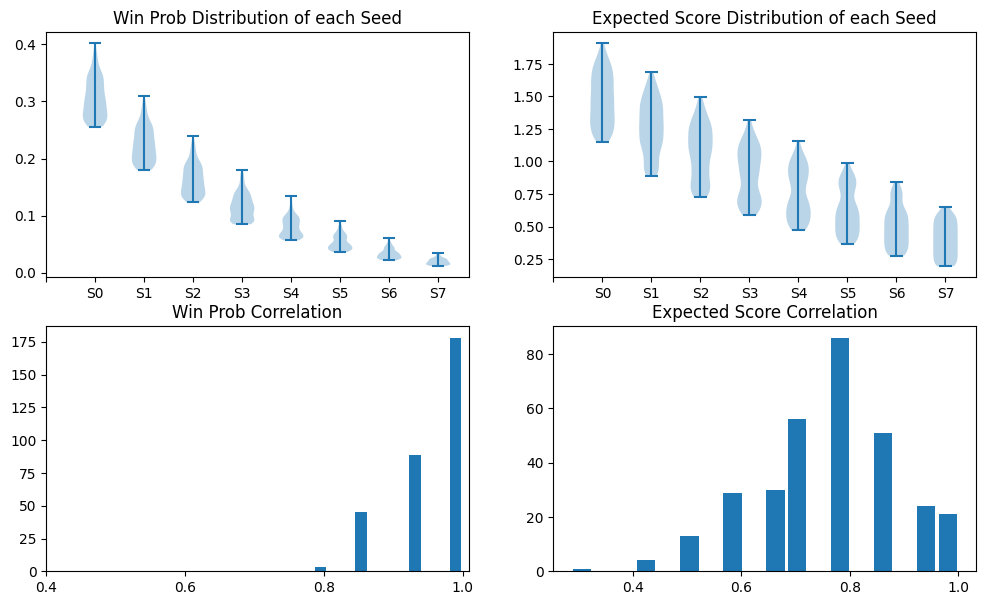

In [7]:
import matplotlib.pyplot as plt

NB = len(labels)

fig, axs = plt.subplots(2, 2, figsize=(12, 7))

win_dist = [[result['WinProb'][i] for result in results] for i in labels]
exp_dist = [[result['ExpectedScore'][i] for result in results] for i in labels]

axs[0][0].violinplot(win_dist)
axs[0][0].set_xticks(list(range(NB+1)), labels=[None]+[f'S{i}' for i in labels])
axs[0][0].set_title('Win Prob Distribution of each Seed')

axs[0][1].violinplot(exp_dist)
axs[0][1].set_xticks(list(range(NB+1)), labels=[None]+[f'S{i}' for i in labels])
axs[0][1].set_title('Expected Score Distribution of each Seed')

axs[1][0].hist(x=[result['GTCOR_WP'] for result in results], bins='auto', rwidth=0.85)
axs[1][0].set_xticks([0.4, 0.6, 0.8, 1.0])
axs[1][0].set_title('Win Prob Correlation')

axs[1][1].hist(x=[result['GTCOR_ES'] for result in results], bins='auto', rwidth=0.85)   
axs[1][1].set_xticks([0.4, 0.6, 0.8, 1.0])
axs[1][1].set_title('Expected Score Correlation')

plt.show()

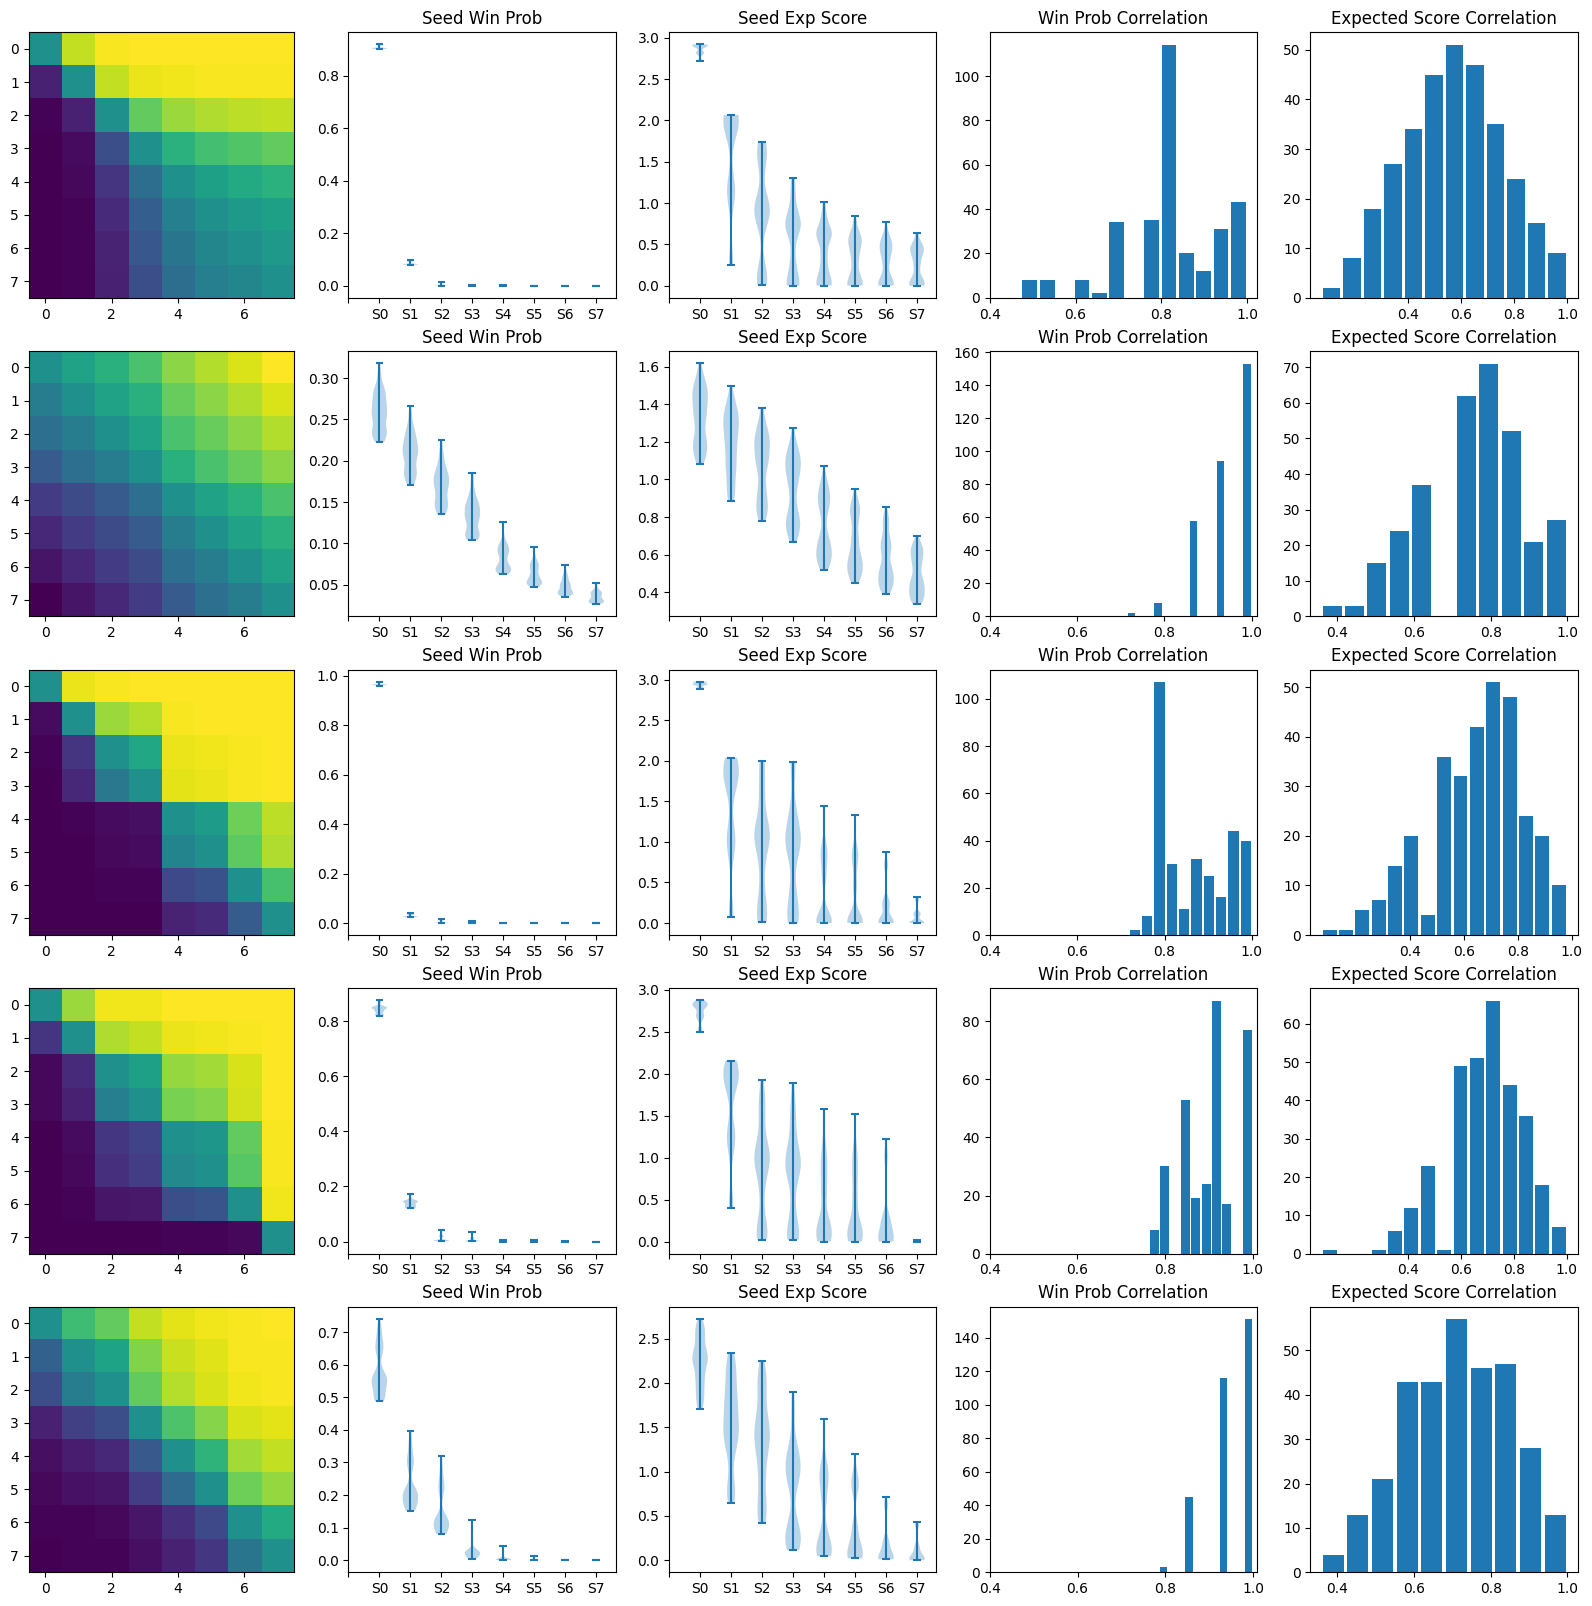

In [8]:
from rstt import BasicPlayer, Duel, BTRanking, LogSolver
from utils import visualisation as visul

def prob_matrix(gt: BTRanking) -> list[list[float]]:
    '''convert rstt model to probability matrix'''
    matrix = []
    for p1 in gt:
        line = []
        for p2 in gt:
            if p1 != p2:
                line.append(round(LogSolver().probabilities(Duel(p1, p2))[0], 2))
            else:
                line.append(0.5)
        matrix.append(line)
    return matrix

# 5 test model
models = [
    prob_matrix(BTRanking('few_elite', [BasicPlayer('Seed{i}', 1000+l) for i, l in zip(labels, [0, 25, 50, 100, 200, 400, 800, 1200])])),
    prob_matrix(BTRanking('dense', [BasicPlayer('Seed{i}', 1000+l) for i, l in zip(labels, [-100, -75, -50, -25, 25, 50, 75, 100])])),
    prob_matrix(BTRanking('gauss1', BasicPlayer.create(nb=8))),
    prob_matrix(BTRanking('gauss2', BasicPlayer.create(nb=8))),
    prob_matrix(BTRanking('gauss3', BasicPlayer.create(nb=8))),
]

# run, analysis & plot
fig, axs = plt.subplots(len(models), 5, figsize=(20, 20))
for matrix, row in zip(models, axs):
    truth = groundtruth(labels, matrix)
    results = compute_bracket(seedings, matrix)
    fav, scoring, mins, maxs, worst_es, worst_wp = analysis(results, labels, truth)
    visul.visualize_bracket_analysis(results, labels, matrix, row)
plt.show()

In [9]:
# print a model analysis summary
model = 2 # len(models)
matrix = models[model]
truth = groundtruth(labels, matrix)
results = compute_bracket(seedings, matrix)
fav, scoring, mins, maxs, worst_es, worst_wp = analysis(results, labels, truth)
visul.summary(fav, scoring, mins, maxs, worst_es, worst_wp, labels)

worst seed regarding winner probabilities (0, 3, 2, 5, 1, 4, 6, 7) 0.7181324987175317
worst seed regarding expected score (0, 1, 2, 3, 4, 5, 6, 7) 0.07142857142857142 

player 0 win prob: min = 0.9603, max = 0.9764, favorite in 315 , topscorer in 315
player 1 win prob: min = 0.0227, max = 0.0384, favorite in 0 , topscorer in 0
player 2 win prob: min = 0.0009, max = 0.0154, favorite in 0 , topscorer in 0
player 3 win prob: min = 0.0000, max = 0.0081, favorite in 0 , topscorer in 0
player 4 win prob: min = 0.0000, max = 0.0003, favorite in 0 , topscorer in 0
player 5 win prob: min = 0.0000, max = 0.0001, favorite in 0 , topscorer in 0
player 6 win prob: min = 0.0000, max = 0.0000, favorite in 0 , topscorer in 0
player 7 win prob: min = 0.0000, max = 0.0000, favorite in 0 , topscorer in 0






## 4.2.3 Protocol

Considering the Bradly-Terry model, we generate n=64 players with a constant level, the game mode is "one-versus-one", and the solver is the LogSolver. The scheduler is a Single Elimination Bracket tournament seeded by an Elo ranking. We perform the \textit{RSSC} loop with $depth = 1000$. Between two tournament editions $event_{i}, event_{i+1}$, the ranking is updated with the games played in $event_i$, and then used to seed $event_{i+1}$. This produces a dataset of $depth * (n-1) = 1000 * 63 =63'000$ ordered games.

For evaluation, we consider 4 moments $m=200,400,600,800$. For each of these moments we generate a training set with games played up to the tournament $event_{m}$, and a test set with all games played after it. We then train and evaluate an Elo ranking. 

As a remark, the evaluation could have been done during the simulation process. We can ask the ranking to make predictions on the games before the updates. The choice to split the simulation from the evaluation was made to have a more realistic empirical approach. I can upload my dataset on the internet, someone else can download it and evaluate his ranking on it. The data production is strictly separated from the system evaluation (here the Elo ranking).

In [10]:
import random
from rstt import SingleEliminationBracket as SEB
from rstt import BasicElo

# Players
population = BasicPlayer.create(nb=64, level_dist=random.gauss, level_params={'mu':1500, 'sigma':500})

# Solver
solver = LogSolver(base=10, lc=400)

# Test Ranking
elo = BasicElo('Elo', players=population)

# Sheduler
scheduler = SEB

# Interaction
depth = 1000

# Ground-Truth
gt = BTRanking('Consensus', population)
gt.plot()

# moments
splits = [200, 400, 600, 800]

----------- Consensus -----------
   0.        Anthony Gaden       2689
   1.         Kelly Kovach       2665
   2.         Lloyd Zavala       2297
   3.         Ileen Thomas       2280
   4.         James Person       2258
   5.         Alan Gilling       2220
   6.        Jean Klebanow       2130
   7.  Charles Chamberlain       2101
   8.         Mark Richter       2080
   9.       Gerald Coleman       2030
  10.      Michael Dawkins       2009
  11.        Eric Fournier       1999
  12.          Eddie White       1915
  13.          Claudia Mix       1907
  14.        Thelma Cortez       1862
  15.       Dorothy Mosley       1776
  16.  Charles Blumenstock       1768
  17.         Edgar Rivera       1740
  18.    Raymond Alcantara       1674
  19.       Charlotte Peco       1643
  20.          Pamela Page       1627
  21.        John Morrison       1600
  22.    Kenneth Hernandez       1568
  23.        Vernon Slaton       1545
  24.        Joseph Gerber       1544
  25.        Mon

In [11]:
from dataclasses import dataclass
from rstt import Ranking
from rstt.stypes import Event, SPlayer, SMatch
from utils.rssc import rssc

@dataclass
class SebEloData:
    ratings: dict[SPlayer, float]
    games: list[SMatch]
    truth: dict[SPlayer, float]

def datasets(ranking: Ranking, event: Event, ref: Ranking):
    return SebEloData(ratings={p: ranking.rating(p) for p in ref},
                      games=event.games(),
                      truth={p: ref.rating(p) for p in ref})


results = rssc(name='SEBELO', seed=elo, cup=scheduler, solver=solver, depth=1000, metric=datasets)

## 4.2.3 Results

In [12]:
import itertools

def load_testset(start: int, end: int, results: list[SebEloData]) -> list[SMatch]:
    return [game for result in results for game in result.games]

def trained_elo(m: int, results: list[SebEloData]) -> BasicElo:
    elo = BasicElo(f'Elo after {m} tournament')
    for p, r in results[m-1].ratings.items():
        elo.set_rating(p, r)
    return elo

def unseen_matchups(players: list[SPlayer], games: list[SMatch]) -> list[tuple[SPlayer, SPlayer]]:
    unseen = []
    for p1, p2 in itertools.combinations(players, 2):
        if not [game for game in games if p1 in game and p2 in game]:
            unseen.append((p1, p2))
    return unseen

In [ ]:
for split in splits:
    data = load_testset(start=split, end=depth, results=results)
    print('loaded')
    ranking = trained_elo(split, results)
    print('recovered')
    new_matchups = unseen_matchups(ranking.players(), data)
    print('extracted')

loaded
recovered
extracted
loaded
recovered
